---

<div align=center>

# 📜 **Abstract**

</div>

## **Breaking the $10^{-8}$ Contrast Barrier: Toward the First Adaptive Photonic Nulling Interferometers for Direct Exoplanet Detection**

The quest for Earth-like exoplanets demands unprecedented instrumental capabilities: contrasts exceeding $10^{-8}$, milliarcsecond angular resolution, and stability over hours of observation. We present one of the first implementations of an **adaptive photonic nulling interferometer**, featuring 14 real-time electro-optic phase shifters integrated within a silicon nitride photonic chip, improving astronomical instrumentation through **on-chip wavefront control without mechanical components**.

This breakthrough instrument combines **Kernel-Nulling interferometry** with **adaptive photonics**, enabling automatic compensation for manufacturing defects and environmental perturbations within milliseconds. Unlike traditional approaches limited by mechanical delay lines and atmospheric turbulence, our **tunable photonic architecture** achieves: (1) **sub-nanometer phase control** with thermal response times under 1 ms; (2) **intrinsic stability**, immune to vibrations and capable of compensating thermal drifts; (3) **scalable integration**, compatible with space missions and large ground-based arrays; and (4) potential **bandwidth adaptability** for spectral diversity.

We demonstrate **two calibration algorithms** that optimize the 14-dimensional parameter space, retrieving an almost ideal Kernel-Nuller device. Advanced **statistical detection frameworks**, combining multiple kernel outputs, enable robust exoplanet characterization even in the presence of phase aberrations exceeding 100 nm RMS. Numerical simulations for **VLTI/ASGARD and LIFE mission architectures** validate detection capabilities for Earth-sized planets in habitable zones.

This **paradigm shift toward adaptive photonic astronomy** opens new frontiers—from compact space-based interferometers to large-scale terrestrial arrays. Our approach provides the **technological foundation for the next generation of exoplanet discovery instruments**. The potential integration of machine learning with adaptive photonics positions this work at the intersection of cutting-edge technology and fundamental astrophysics, directly addressing the grand challenge of finding life beyond our solar system.

---

<div align=center>

# ❗**Assumptions**

</div>

+ The banwidth $Δλ$ is small enough to consider that:
  - The flux is constant for all wavelengths $\rightarrow F_λ = F$
  - The refractive index of the material is constant over the bandwidth $\rightarrow n_λ = n$ so phase shifters can be considered as pistons. We then express the phase shifts as OPDs (in distance unit).
+ The star is not resolved so it can be associated to a point source.

---

<div align=center>

# 🤔 **Context**

</div>

## 🎯 Goal

We aim to detect make direct detection of exoplanets. There is two main challenges to achieve this goal:
- The **contrast**: the exoplanet is much fainter than the star it orbits. The contrast is typically of the order of $10^{-6}$ to $10^{-10}$.
- The **angular separation**: the exoplanet is very close to the star. The angular separation depend on the distance of the exoplanet to the star and the distance of the star to the observer and can easily goes below the arcsecond.

## 🔎 Detection methods

It exist several methods to detect exoplanets. The most common are:
- **Radial velocity method**: the exoplanet induce a wobble in the star it orbits. This wobble can be detected by the Doppler effect (the light is alternatively redshifted and blueshifted).
- **Transit method**: the exoplanet pass in front of the star and block a fraction of the light. This fraction can be detected by the decrease of the star luminosity.
- **Microlensing**: the exoplanet act as a lens and magnify the light of a background star. This magnification can be detected by the increase of the star luminosity.
- **Astrometry**: the exoplanet induce a wobble in the star it orbits. This wobble can be detected by the change of the star position.
- **Coronography**: the exoplanet is directly imaged. This is the most challenging method because of the contrast and the angular separation.

<div align=center>
<img src="docs/img/detection_methods.jpg" width=500px>
<p><i>Paul Anthony Wilson - Exoplanet detection techniques</i><p>
</div>

Until now, the coronography was the only method allowing direct detection. But it has two main limitations:
- It require huge telescopes in order to have a good angular resolution.
- The contrast we can achieve is limited by unperfect fabrication process of the optical components which lead to undesired diffraction effects.

## ➖ Nulling

This is where the Nulling technic $^1$ come into play. The idea is to use two several telescopes and take advantage of destructives interferances to cancel the star light and using the fact that the planet is not perfectly in the line of sight, which will lead to an unperfect destructive interference, or in best scenarios, on constructive ones! This is a very challenging technic because it is highly phase sensitive and require a very good control of the optical path.

<div align=center>
<img src="docs/img/nulling_principle.jpg" width=500px>
</div>

In a perfect 2-telescope nulling system, we can express the two acquired electric field (cf. section "Signal nature" below) in a vector:

$$
E = \begin{pmatrix}
E_1 \\
E_2
\end{pmatrix}
$$

And then express the nulling operation using the following matrix:

$$
N = \begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}
$$

Such as it gives us two outputs with a constructive and a destructive interference (we will focus on the latter):

$$
N \cdot E = \begin{pmatrix}
E_1 + E_2 \\
E_1 - E_2
\end{pmatrix}
$$

> **References**
> 1. Bracewell, R.N., MacPhie, R.H., 1979. Searching for nonsolar planets. Icarus 38, 136–147. https://doi.org/10.1016/0019-1035(79)90093-9

cf. `mmi.py`

## 📡 Projected telescope position

The interferometry process depend on the projected geometry of the telescope position in the plane perpendicular to the line of sight. For each observation, we will then need to compute these projected positions in order to have the correct baseline lenght (and thus the correct phase shifts).\
These projected location can be computed using the following formula $^{1,2}$:

$$
\begin{pmatrix}
u \\
v
\end{pmatrix} =
\begin{pmatrix}
- \sin(l) \sin(h) & \cos(h)\\
\sin(l) \cos(h) \sin(\delta) + \cos(l) \cos(\delta) & \sin(h) \sin(\delta)
\end{pmatrix}
\begin{pmatrix}
B_\text{north} \\
B_\text{east}
\end{pmatrix}
$$

with
- $l$ the latitude of the observatory
- $h$ the hour angle
- $\delta$ the declination of the star

> *Rerefence*
> 1. Chingaipe, P.M. et al., 2023. High-contrast detection of exoplanets with a kernel-nuller at the VLTI. A&A 676, A43. https://doi.org/10.1051/0004-6361/202346118
> 2. Ségransan, D., 2007. Observability and UV coverage. New Astronomy Reviews 51, 597–603. https://doi.org/10.1016/j.newar.2007.06.005

cf. `project_position_njit()` in `src.classes.context.py`

In [1]:
from src import analysis
import astropy.units as u

ctx = analysis.contexts.get_VLTI()
ctx.Δh = 24 * u.hourangle

analysis.projected_telescopes.gui(ctx, 50)

-24.6275 deg


## 🔆 Signal nature

The star and the planet are point sources. Seen from a classical telescope, it will result in an image made of the objects convolution with the point spread function (PSF) of the telescope.

$$
I = O \otimes PSF
$$

Here we consider the most simple PSF : the Airy disk. The Airy disk is the diffraction pattern of a point source by a circular aperture. It is given by:

$$
PSF = \left(\frac{2J_1(x)}{x}\right)^2
$$

where $J_1$ is the Bessel function of the first kind of order 1 and $x = \frac{2\pi r}{\lambda f}$ is the normalized radius of the Airy disk.

Then, we focus the image in a monomode optical fiber which will basically only keep the main lobe of the PSF and reshape it in a Gaussian form. In this process, we lose the spatial information so we have no longer images, but the light flux of each object in the fiber can be simply described by a complex number.

Using this formalism, the light flux of the star and the planet can  be described by only 2 complex numbers for each telescope, giving the amplitude and phase of each object.

cf. `signals.py`

## 🔉 Photon noise

The photon noise is the noise due to the quantization of the light in photons. It is a Poisson noise and can be described by the following formula:

$$
\sigma = \sqrt{N}
$$

where $N$ is the number of photons.

The number of photons can be computed using the Light flux $F_\lambda$ of the star and the planet, the collecting area $A$ of the telescope, the bandwidth $\Delta \lambda$, the transmission efficiency $\eta$, the magnitude $M$ of the star, and the energy of a photon $E_\nu$ at the frequency $\nu$.

Light flux is expressed in Jensky:
$$
1\:\text{Jensky} = 1\:Jy = 10^{-26}\:W/m^2/Hz = 10^{-26}\:J/s/m^2/Hz
$$
The flux at zero magnitude $F_\lambda$ for a star at different wavelengths is given by tables. The following one is an example for AB class stars such as Vega $^1$:

| Band | $\lambda$ ($\mu m$) | $F_\lambda$ ($Jy$) |
|------|---------------------|--------------------|
| V    | 0.55                | 3540               |
| J    | 1.21                | 1630               |
| H    | 1.65                | 1050               |
| K    | 2.17                | 655                |
| L    | 3.55                | 276                |

The number of acquired photons per second is given by:

$$
N = F_\lambda \times A \times \Delta \nu \times \eta \times 10^{-\frac{M}{2.5}} / E_\nu
$$

where $A$ is the collecting area of the telescope, $\Delta \nu$ is the bandwidth, $\eta$ is the transmission efficiency of the system, $M$ is the magnitude of the star, and $E_\nu$ is the energy of a photon at the frequency $\nu$.

We can also express the bandwidth and eneergy in terms of the wavelength:
$$
\Delta \nu = \frac{c}{\lambda^2} \Delta \lambda
$$
$$
E_\nu = \frac{h \times c}{\lambda}
$$

where $c$ is the speed of light, $h$ is the Planck constant.

> **References**
> 1. Allen's Astrophysical Quantities

cf. `signals.py`

## 🏮 MMI

The nulling operation is made using Multi Mode Interferometer (MMI). It consist in a multimode waveguide taking several monomode fibers as input and output. The multimode waveguide is shaped in order to produce a specific interference operation, such as spreading the light of an input on all the output, or opposite, gathering the light of all the input on a single output.

To design a simple nuller, we then need a 2x2 MMI that gather (ie. create a constructive interference) all the input light on a single output. The other output is then a "nulled" output, where there is actually all the inputs light but in phase opposition, resulting in a destructive interference.

<div align=center>
<img src="docs/img/mmi.png" width=400px>

*Numerical simulation of a 3x3 gathering MMI, taken from the paper of Cvetojevic et. al., 2022 $^1$*

</div>

> **Reference**
> 1. Cvetojevic, N. et al., 2022. 3-beam self-calibrated Kernel nulling photonic interferometer. arXiv e-prints. https://doi.org/10.48550/arXiv.2206.04977

## 🔀 Recombiner

The recombiner is also an MMI that will place the signals in phase quadrature. A particularity is that the output of the recombiner contain a symmetry. We will take advantage of this in the Kernel step.

<div align=center>
<img src="docs/img/recombiner.png" width=500px>

*Action of a 2x2 recombiner MMI, taking 2 different combination of 4 nulled signals as input. Taken from the paper of Romain Laugier et al., 2020 $^1$*

</div>

In a 2 input case, we can express the recombiner operation using the following matrix:

$$  
R = \frac{1}{\sqrt{2}}\begin{pmatrix}
e^{i\pi/4} & e^{-i\pi/4} \\
e^{-i\pi/4} & e^{i\pi/4}
\end{pmatrix}
$$

> **Reference**
> 1. Laugier, R., Cvetojevic, N., Martinache, F., 2020. Kernel nullers for an arbitrary number of apertures. A&A 642, A202. https://doi.org/10.1051/0004-6361/202038866

cf. `mmi.py`


## 💠 Kernel

The idea of the kernel is to acquire and substract the pairs of recombined output. As these pairs share symmetrical properties, this substraction will cancel the star light even with first order phase aberations while keeping the planet light!

Moreover, it modify the nuller response (cf. "Transmission maps" section below) in an asymetric way which is interesting for us as it gives us more information to constrain the planet position.

Demonstration (cf. `demonsration.py`):

In [2]:
from src import analysis
analysis.demonstration.show()

Input intensities:


I[a, p] + I[a, s]

I[b, p] + I[b, s]

Fields contributions:


Abs(E[1, p] + E[2, p] + E[3, p] + E[4, p])**2 + Abs(E[1, s] + E[2, s] + E[3, s] + E[4, s])**2

Abs(E[1, p] + E[2, p] + E[3, p] + E[4, p])**2 + Abs(E[1, s] + E[2, s] + E[3, s] + E[4, s])**2

Decomposition in amplitudes and phases:


((-I*exp(I*phi[2])*theta[2] - exp(I*phi[2]) - exp(I*phi[3])*theta[3] + I*exp(I*phi[3]) + exp(I*phi[4])*theta[4] - I*exp(I*phi[4]))*exp(I*(phi[2] + phi[3] + phi[4]))*A[p]**2 + (A[p]**2*theta[2]**2 + A[p]**2*theta[3]**2 + A[p]**2*theta[4]**2 + 4*A[p]**2 + A[s]**2*theta[2]**2 + A[s]**2*theta[3]**2 - 2*A[s]**2*theta[3]*theta[4] + A[s]**2*theta[4]**2)*exp(I*(phi[1] + phi[2] + phi[3] + phi[4])) + (-exp(I*phi[1])*theta[3] - I*exp(I*phi[1]) + I*exp(I*phi[2])*theta[2]*theta[3] - exp(I*phi[2])*theta[2] + exp(I*phi[2])*theta[3] + I*exp(I*phi[2]) - exp(I*phi[4])*theta[3]*theta[4] + I*exp(I*phi[4])*theta[3] - I*exp(I*phi[4])*theta[4] - exp(I*phi[4]))*exp(I*(phi[1] + phi[2] + phi[4]))*A[p]**2 + (exp(I*phi[1])*theta[4] + I*exp(I*phi[1]) - I*exp(I*phi[2])*theta[2]*theta[4] + exp(I*phi[2])*theta[2] - exp(I*phi[2])*theta[4] - I*exp(I*phi[2]) - exp(I*phi[3])*theta[3]*theta[4] - I*exp(I*phi[3])*theta[3] + I*exp(I*phi[3])*theta[4] - exp(I*phi[3]))*exp(I*(phi[1] + phi[2] + phi[3]))*A[p]**2 + (I*exp(I*phi[1]

((-I*exp(I*phi[2])*theta[2] - exp(I*phi[2]) + exp(I*phi[3])*theta[3] - I*exp(I*phi[3]) - exp(I*phi[4])*theta[4] + I*exp(I*phi[4]))*exp(I*(phi[2] + phi[3] + phi[4]))*A[p]**2 + (A[p]**2*theta[2]**2 + A[p]**2*theta[3]**2 + A[p]**2*theta[4]**2 + 4*A[p]**2 + A[s]**2*theta[2]**2 + A[s]**2*theta[3]**2 - 2*A[s]**2*theta[3]*theta[4] + A[s]**2*theta[4]**2)*exp(I*(phi[1] + phi[2] + phi[3] + phi[4])) + (exp(I*phi[1])*theta[3] + I*exp(I*phi[1]) - I*exp(I*phi[2])*theta[2]*theta[3] + exp(I*phi[2])*theta[2] - exp(I*phi[2])*theta[3] - I*exp(I*phi[2]) - exp(I*phi[4])*theta[3]*theta[4] + I*exp(I*phi[4])*theta[3] - I*exp(I*phi[4])*theta[4] - exp(I*phi[4]))*exp(I*(phi[1] + phi[2] + phi[4]))*A[p]**2 + (-exp(I*phi[1])*theta[4] - I*exp(I*phi[1]) + I*exp(I*phi[2])*theta[2]*theta[4] - exp(I*phi[2])*theta[2] + exp(I*phi[2])*theta[4] + I*exp(I*phi[2]) - exp(I*phi[3])*theta[3]*theta[4] - I*exp(I*phi[3])*theta[3] + I*exp(I*phi[3])*theta[4] - exp(I*phi[3]))*exp(I*(phi[1] + phi[2] + phi[3]))*A[p]**2 + (I*exp(I*phi[1]

Difference between the signals


2*((-exp(I*phi[3])*theta[3] + I*exp(I*phi[3]) + exp(I*phi[4])*theta[4] - I*exp(I*phi[4]))*exp(I*(phi[2] + phi[3] + phi[4])) + (-exp(I*phi[1])*theta[3] - I*exp(I*phi[1]) + I*exp(I*phi[2])*theta[2]*theta[3] - exp(I*phi[2])*theta[2] + exp(I*phi[2])*theta[3] + I*exp(I*phi[2]))*exp(I*(phi[1] + phi[2] + phi[4])) + (exp(I*phi[1])*theta[4] + I*exp(I*phi[1]) - I*exp(I*phi[2])*theta[2]*theta[4] + exp(I*phi[2])*theta[2] - exp(I*phi[2])*theta[4] - I*exp(I*phi[2]))*exp(I*(phi[1] + phi[2] + phi[3])) + (-I*exp(I*phi[3])*theta[2]*theta[3] - exp(I*phi[3])*theta[2] + exp(I*phi[3])*theta[3] - I*exp(I*phi[3]) + I*exp(I*phi[4])*theta[2]*theta[4] + exp(I*phi[4])*theta[2] - exp(I*phi[4])*theta[4] + I*exp(I*phi[4]))*exp(I*(phi[1] + phi[3] + phi[4])))*exp(-I*(phi[1] + phi[2] + phi[3] + phi[4]))*A[p]**2

## 🌡️ Thermo-optic phase shifter

In practice, we are often limited by the fabrication process of the optical components. The imperfections can lead into phase aberations that will degrade the Kernel-Nuller performance. An attempt to correct these aberations consist in using thermo-optic phase shifters. It consist in a waveguide with a heater that will modify the refractive index of the waveguide and thus the phase of the light passing through it.

As the size of the waveguide is very small, the thermal inertia is very low and the phase can be modified very quickly, in a milisecond time scale. This is a very interesting solution to correct phase aberations, even in real time if we encounter variable phase aberation sources.

<div align=center>
<img src="docs/img/thermo-optic_phase_shifter.png" width=500px>
</div>

In this simulation, one will simply modelize these phase shifter as a phase shift in the signal.

$$
P = e^{i\phi} = e^{i\frac{2\pi}{\lambda} \Delta L}
$$

Where $\phi$ and $\Delta L$ are proportional to the power injected in the heater.

cf. `phase.py`

---

<div align=center>

# 💡 **Our approach**

</div>

## 🏗️ Current architecture

To implement the 4 telescope tunable Kernel-Nuller, we splitted the 4x4 MMI into series of 2x2 MMI separated by phase shifters.

<div align=center>
<img src="docs/img/scheme.png" width=1000px>

*Architecture of our Kernel-Nuller. N squares are the 2x2 nullers, S squares are the 2x2 recombiners and P rectangles are the phase shifters*

</div>

cf. `kn.py`

## 🗺️ Transmission maps

The nulling technic with two telescope show a limitation: if the planet light arrive on the two telescopes with a phase shift of $2n\pi$, the light will also be cancelled. It result in a comb-shaped transmission map $^1$, perpendicular to the baseline (there is clear bands where it's optimal to detect the planet and black bands where we will mostly destroy the planet light).

The idea of Bracewell was to rotate the baseline in order to let the planet pass through the clear bands at some point. After an entire rotation of the baseline, we will have a sinusoidal signal from which the frequency will indicate us the distance of the planet to it's star, and the phase will give us a clue about the angle between the axes star-planet and the axes of the baseline. Thus, as the transmission map is symmetric, we can constrain the planet position to 2 possible locations, on both sides of the star.

Here, we are using 4 telescopes, resulting in more complexe transmission maps than simple combs, but the principle is the same.

> **Reference**
> 1. Bracewell, R.N., MacPhie, R.H., 1979. Searching for nonsolar planets. Icarus 38, 136–147. https://doi.org/10.1016/0019-1035(79)90093-9

cf. `transmission_map.py`

In [3]:
from src import analysis
import astropy.units as u
import numpy as np

ctx = analysis.contexts.get_LIFE()
ctx.Δh = 24*u.hourangle
ctx.Γ = 0 * u.m
ctx.interferometer.fov = 20 * u.mas
ctx.interferometer.kn.σ = np.zeros(14) * u.m

analysis.transmission_maps.gui(ctx)

---

<div align=center>

# 🪛 **Calibration**

</div>

## 🫳 Manual shift controls

In [4]:
from src import analysis
import astropy.units as u
import numpy as np

# analysis.manual_control.gui(λ=1.65 * u.um, φ=np.zeros(14) * u.nm, σ=np.abs(np.random.normal(0,100, 14)) * u.nm)
analysis.manual_control.gui(λ=1.65 * u.um, φ=np.zeros(14) * u.nm, σ=np.zeros(14) * u.nm)

## 🧬 Genetic

in order to get the best shifts to inject to optimize the component performances, I made a genetic algorithme that iteratively mutate a shifter and keep the mutation if it minimize the associated metric. All the shifters that act on the bright channel are associated with the bright metric that must be maximized

$$
M_B = |B|^2
$$

While the other shifters are associated with the kernel metric that must be minimized.

$$
M_K = \sum_{n=1}^3|K_n|
$$

Merging these two metrics can induce local minimum since improving the bright metric can deterior the kernel metric. This separation is then necessary to ensure reaching a global minimum (empirically demonstrated)

> **Acknowledgment**
> - Romain Laugier for the idea of merging the metrics

Performances in lab (Γ=0)
Achieved Kernel-Null depth:
   Mean: 7.36e-07 | 1.88e-07 | 2.22e-07
   Med:  7.36e-07 | 1.88e-07 | 2.22e-07
   Std:  1.56e-08 | 1.55e-08 | 4.14e-09

Performances in space (Γ=1 nm)
Achieved Kernel-Null depth:
   Mean: 7.37e-07 | 1.88e-07 | 2.22e-07
   Med:  7.36e-07 | 1.88e-07 | 2.21e-07
   Std:  8.18e-08 | 7.02e-08 | 3.62e-08

Performances in atmosphere (Γ=100 nm)
Achieved Kernel-Null depth:
   Mean: 1.67e-05 | -2.21e-06 | -2.88e-06
   Med:  1.52e-05 | -9.02e-06 | -6.00e-06
   Std:  3.14e-04 | 3.03e-04 | 3.22e-04


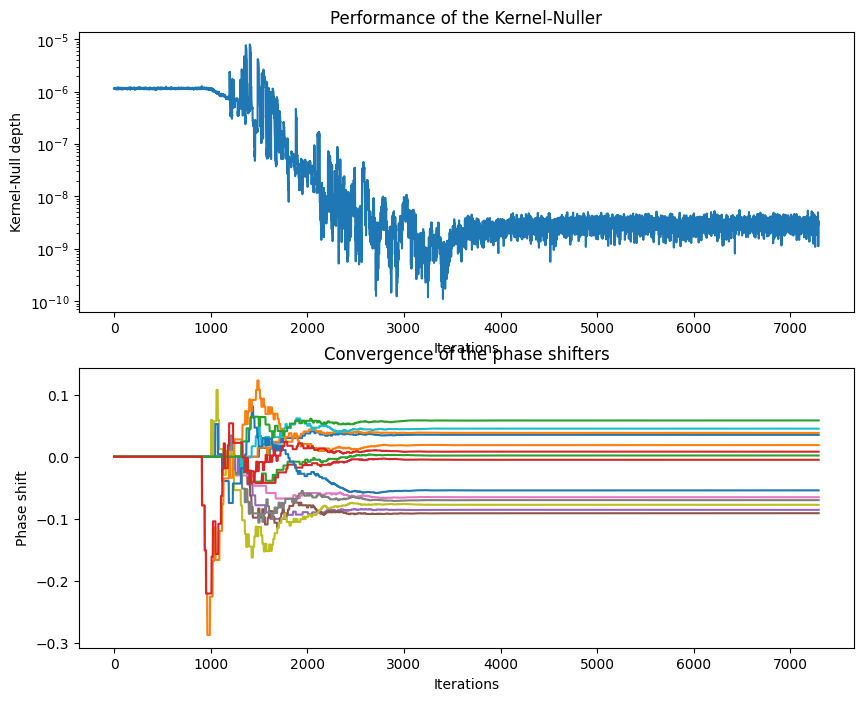

Performances in lab (Γ=0)
Achieved Kernel-Null depth:
   Mean: 2.48e-09 | -7.48e-10 | 1.12e-09
   Med:  2.47e-09 | -7.67e-10 | 1.11e-09
   Std:  5.81e-10 | 3.87e-10 | 5.29e-10

Performances in space (Γ=1 nm)
Achieved Kernel-Null depth:
   Mean: 2.48e-09 | -7.13e-10 | 1.02e-09
   Med:  2.17e-09 | -7.23e-10 | 8.35e-10
   Std:  4.86e-09 | 1.95e-09 | 4.42e-09

Performances in atmosphere (Γ=100 nm)
Achieved Kernel-Null depth:
   Mean: -1.78e-05 | -7.49e-06 | -1.40e-05
   Med:  -1.71e-05 | 1.37e-06 | -1.09e-05
   Std:  3.12e-04 | 2.99e-04 | 2.98e-04


In [3]:
from src import analysis
ctx = analysis.contexts.get_LIFE()
ctx.observe = ctx.observe_monochromatic
_ = analysis.calibration.genetic_approach(ctx=ctx, β=0.961, verbose=False, figsize=(10,8))

## 👁️ Obstruction

En obstruant successivement une paire d'entrées, il est possible de simplifier le problème d'optimisation en ne jouant que sur un seul paramètre et en ne regardant qu'une seule sortie.

Il existe différentes façon de procéder. Je ne vais détailler ici que l'une d'entre elles.

On commence par obstruer les entrées $I_2$ et $I_3$. Au regard de l'architectue de notre composant, on peut alors décrire la fonction de transfert pour la sortie brillante $B$

$$
B = \left|\left(a_1 e^{i(\theta_1 + \sigma_1 + \phi_1)} + a_2 e^{i(\theta_2 + \sigma_2 + \phi_2)}\right) e^{i(\sigma_5 + \phi_5)}\right|^2
$$

Où $a_n$ et $\theta_n$ représentent respectivement l'amplitude et la phase des signaux d'entrée. $\sigma_n$ correspond à la perturbation de phase (inconnue) associé au retardateur $n$ et $\phi_n$ est la phase que l'on inject volontairement via le retardateur pour tenter de compenser cette perturbation.

La calibration se faisant en laboatoire, on peut supposer une intensité totale fixée à $1$ (unité arbitraire) et que chaque entrée recçoi le même flux soit $a_1 = a_2 = 1/\sqrt{2}$, et parfaitement cophasé, soit $\theta_1 = \theta_2 = \theta$. Etant donné que l'on a accès qu'a l'intensité du signal, nous sommes insensible à la phase globale, ce qui permet de simplifier l'équation précédente :

$$
B = \frac{1}{2} \left|e^{i(\sigma_1 + \phi_1)} + e^{i(\sigma_2 + \phi_2)}\right|^2
$$

En maximisant $B$, on devrait alors trouver $1$ ce qui implique que

$$
\sigma_1 + \phi_1 = \sigma_2 + \phi_2
$$

On peut utiliser $\phi_1$ comme référence (phase globale) et ainsi le fixer à 0, ce qui donne alors

$$
\phi_2 = \sigma_1 - \sigma_2
$$

On peut alors soit effectuer différentes mesures de $B$ à $\phi_2$ fixé et en déduire $\sigma_1$ et $\sigma_2$ par résolution d'un système déquation, soit trouver dichotomiquement la valeur de $\phi_2$ qui maximise $B$.

e:\Tunable-Kernel-Nulling\.venv\Lib\site-packages\fitter\__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Performances in lab (Γ=0)
Achieved Kernel-Null depth:
   Mean: 5.45e-06 | -3.18e-05 | 7.41e-06
   Med:  5.45e-06 | -3.18e-05 | 7.41e-06
   Std:  4.13e-08 | 5.73e-08 | 4.11e-08

Performances in space (Γ=1 nm)
Achieved Kernel-Null depth:
   Mean: 5.44e-06 | -3.19e-05 | 7.43e-06
   Med:  5.45e-06 | -3.18e-05 | 7.28e-06
   Std:  9.92e-07 | 5.02e-06 | 1.67e-06

Performances in atmosphere (Γ=100 nm)
Achieved Kernel-Null depth:
   Mean: 2.22e-04 | -1.92e-06 | -2.51e-04
   Med:  -6.29e-05 | 5.70e-05 | -1.97e-05
   Std:  1.33e-02 | 1.41e-02 | 1.26e-02


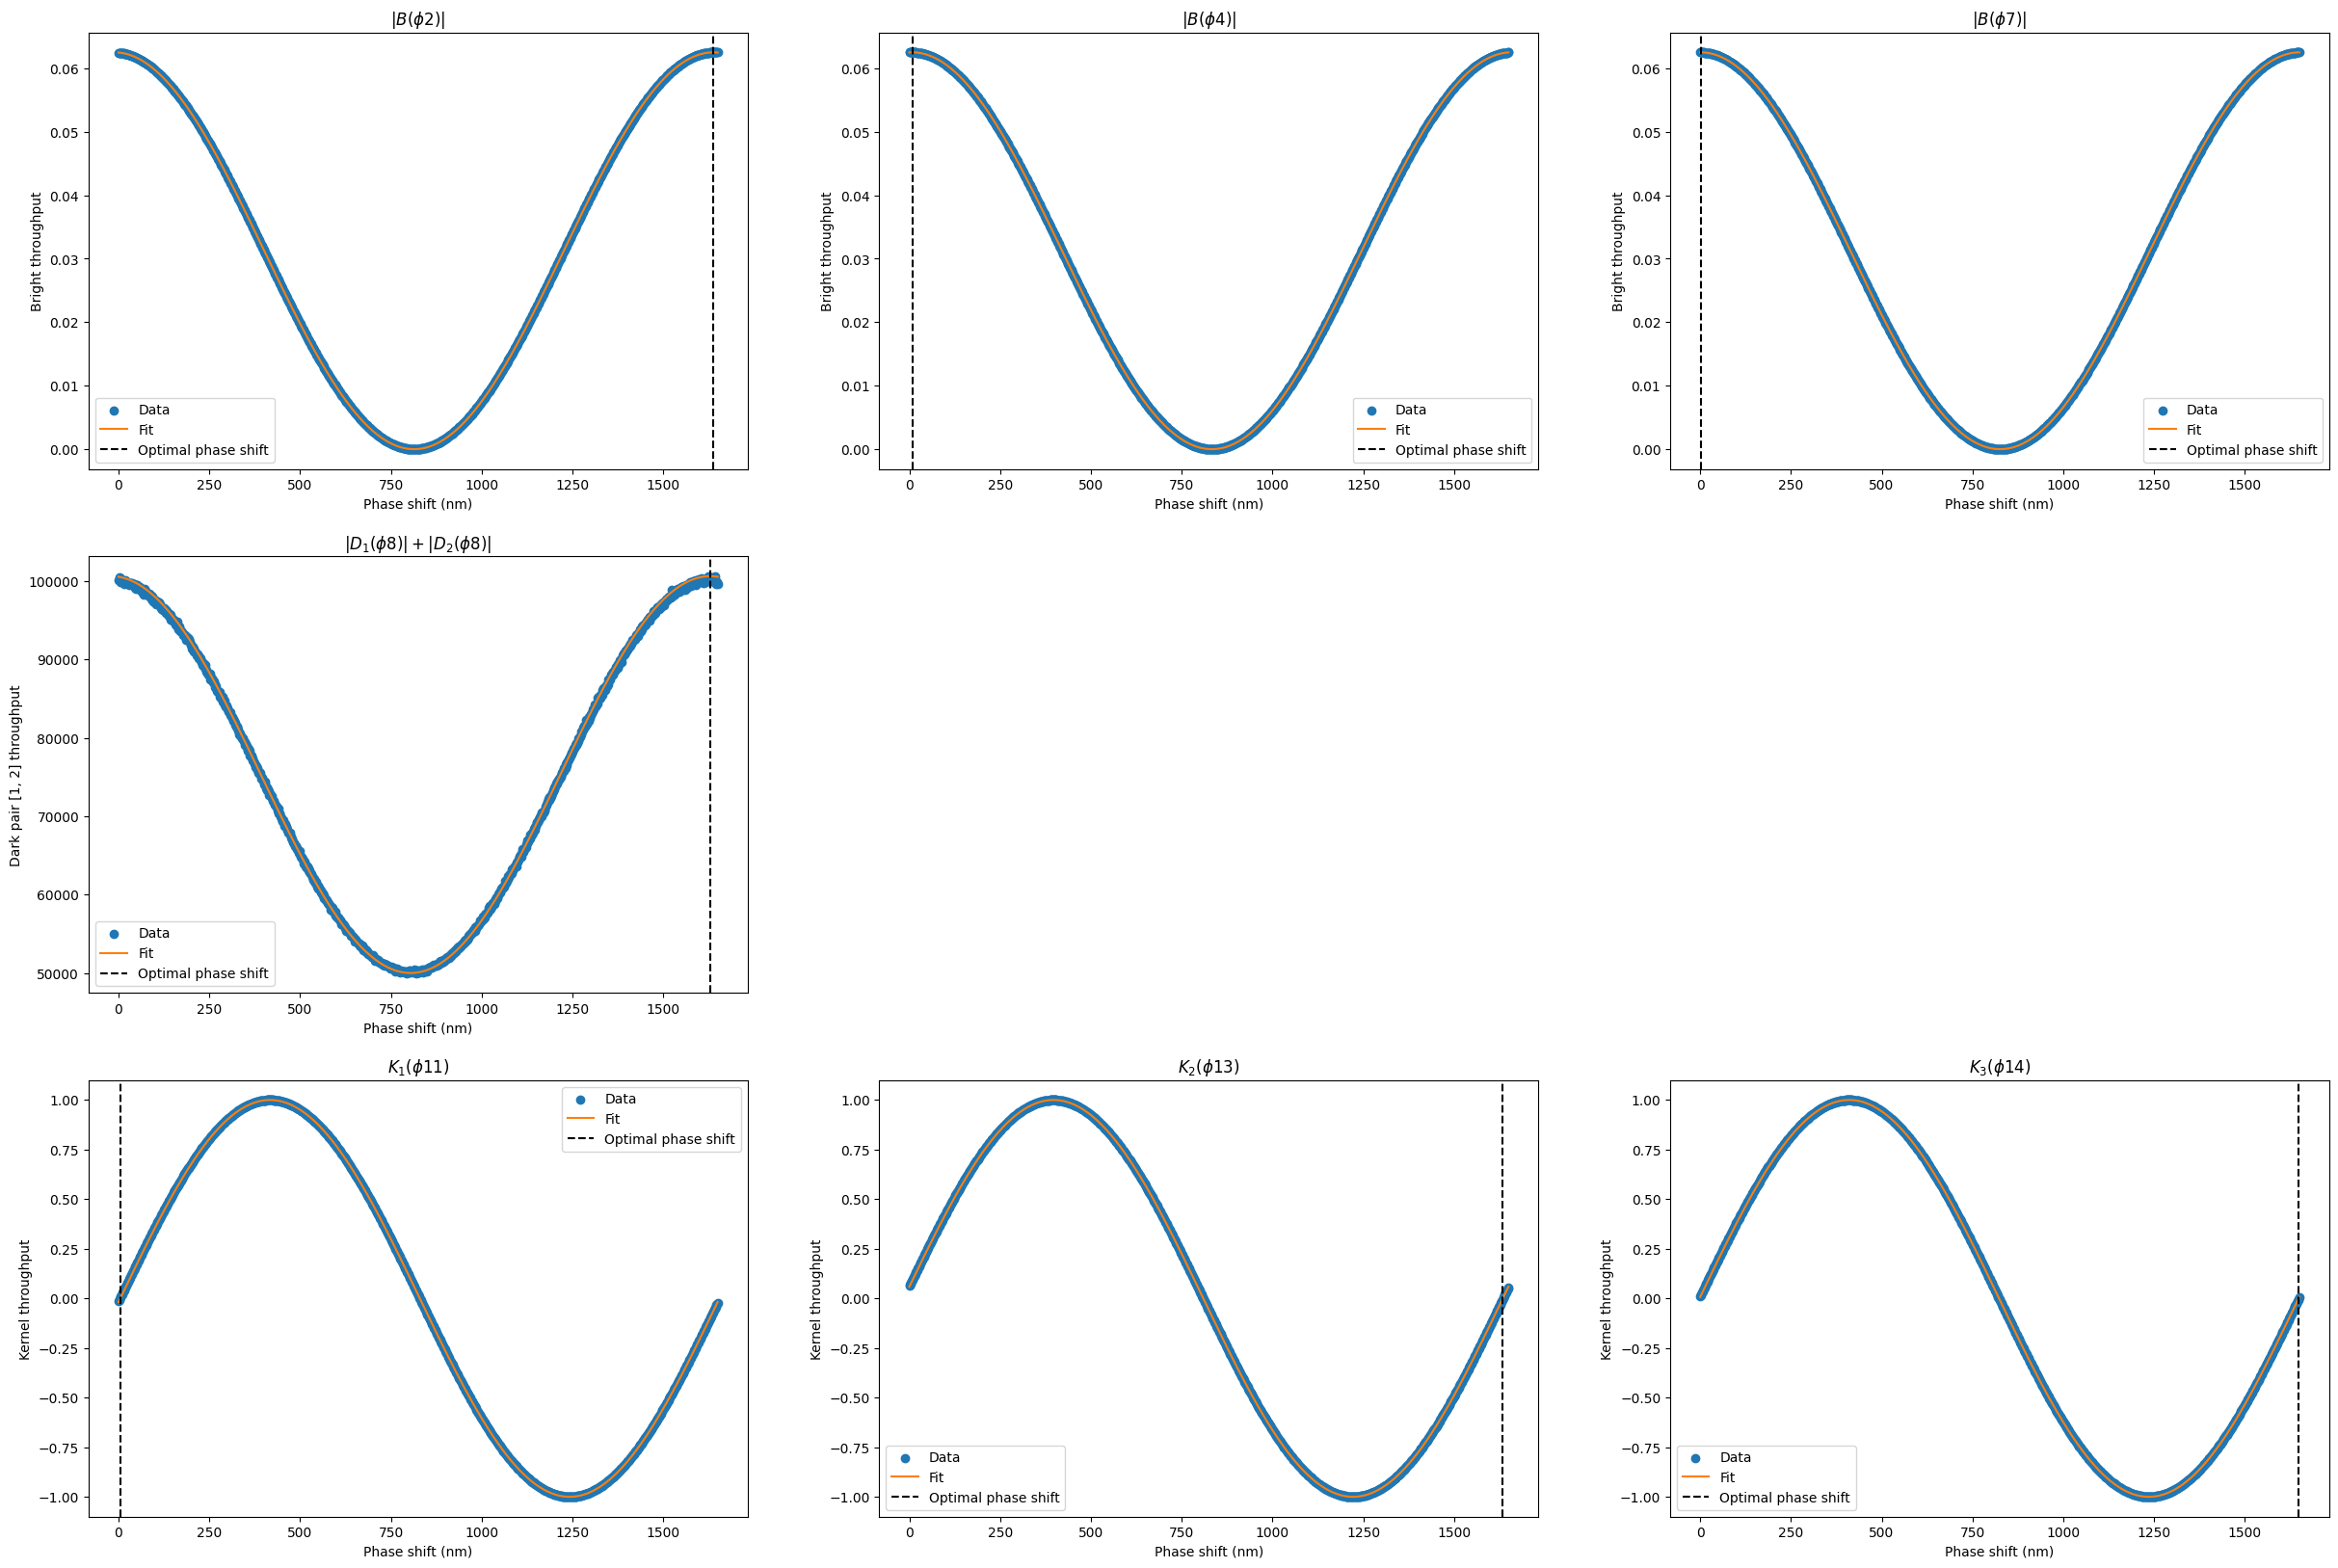

Performances in lab (Γ=0)
Achieved Kernel-Null depth:
   Mean: 3.68e-09 | 1.21e-10 | 2.13e-10
   Med:  3.60e-09 | 1.19e-10 | 3.07e-10
   Std:  4.74e-09 | 3.37e-09 | 3.35e-09

Performances in space (Γ=1 nm)
Achieved Kernel-Null depth:
   Mean: 3.38e-09 | 9.13e-10 | -5.58e-10
   Med:  8.56e-10 | 8.61e-10 | 2.29e-11
   Std:  2.38e-08 | 2.16e-08 | 2.58e-08

Performances in atmosphere (Γ=100 nm)
Achieved Kernel-Null depth:
   Mean: -3.10e-04 | -4.49e-05 | -3.59e-04
   Med:  -7.14e-06 | -1.70e-05 | -2.26e-05
   Std:  1.42e-02 | 1.37e-02 | 1.32e-02


In [1]:
from src import analysis

ctx = analysis.contexts.get_VLTI()
ctx.observe = ctx.observe_monochromatic
_ = analysis.calibration.obstruction_approach(n=1000, ctx=ctx)

## 🧐 Comparison

In [7]:
from src import analysis
# analysis.calibration.compare_approaches(β=0.99, n=10_000)

## 🤖 Machine Learning

Another approach to retrieve the correct shifts inject is to use machine learning techniques. There is several ways to do so. Here we will focus a supervised dense neural network. To do so, we will have to build a dataset.

As the solutions are degenerated, we will not ask the network to predict the best shift to inject, but we will ask it to predict the shfit aberrations instead. From these aberation, we are able to determine a solution for the shifts to inject.

As input of the network, we need to give enough information to caracterize the parameter space. The most straightforward approach would be to create a grid in the parameter space and give the kenrel outputs for each of the point in these grid.

Unfortunately, we work in a parameter space of 14 dimensions which is too large to be covered by a grid. A solution is to consider only the vectors that form the cardinal basis of this parameter space.

In [8]:
# TODO: refactor the following code
# DATASET = ml.get_dataset(10_000)
# print(DATASET.shape)
# MODEL = ml.get_model(input_shape=DATASET.shape[1]-14)
# MODEL.summary()
# ml.train_model(plot=True)
# ml.test_model()

---

<div align=center>

# ⚙️ **Data generation**

</div>

First, let's generate the different scenes we will compare:

## 🟨 Instantaneous serie

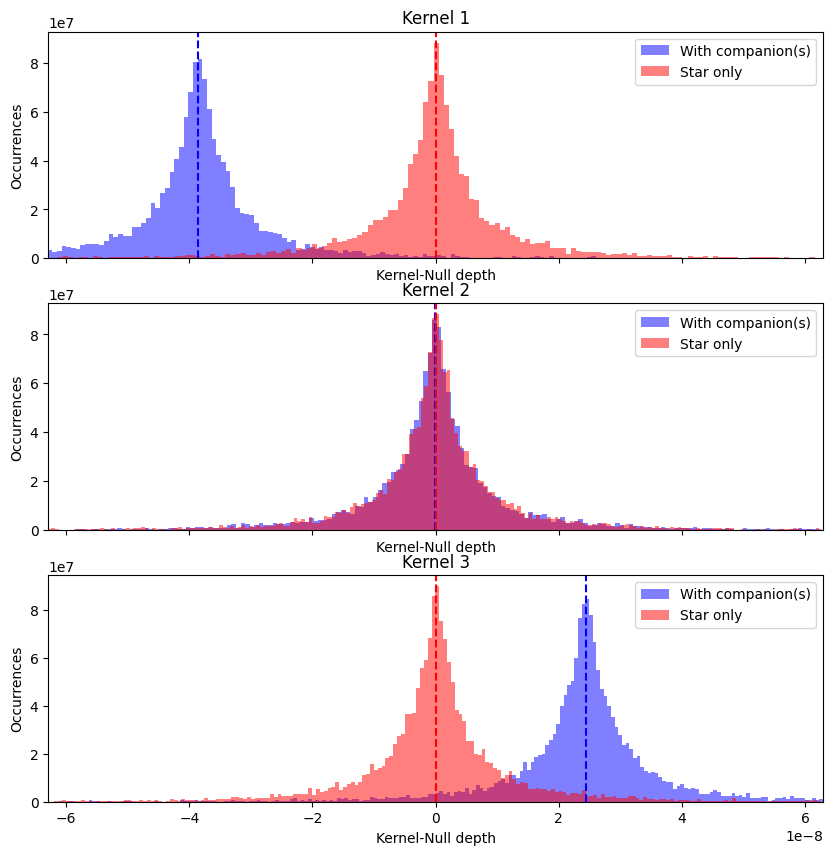

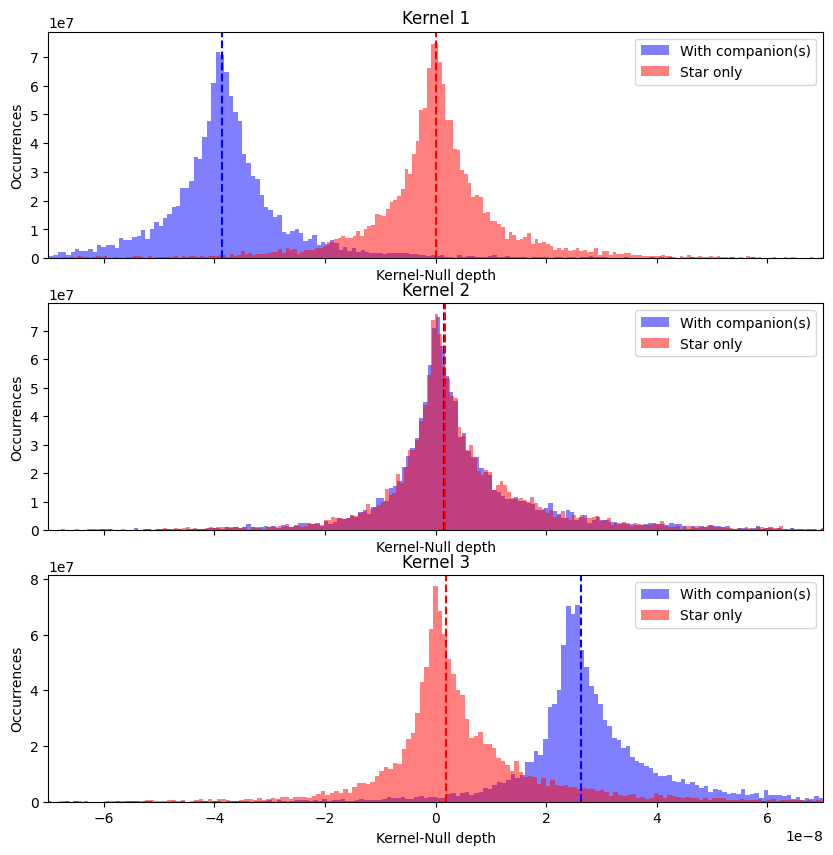

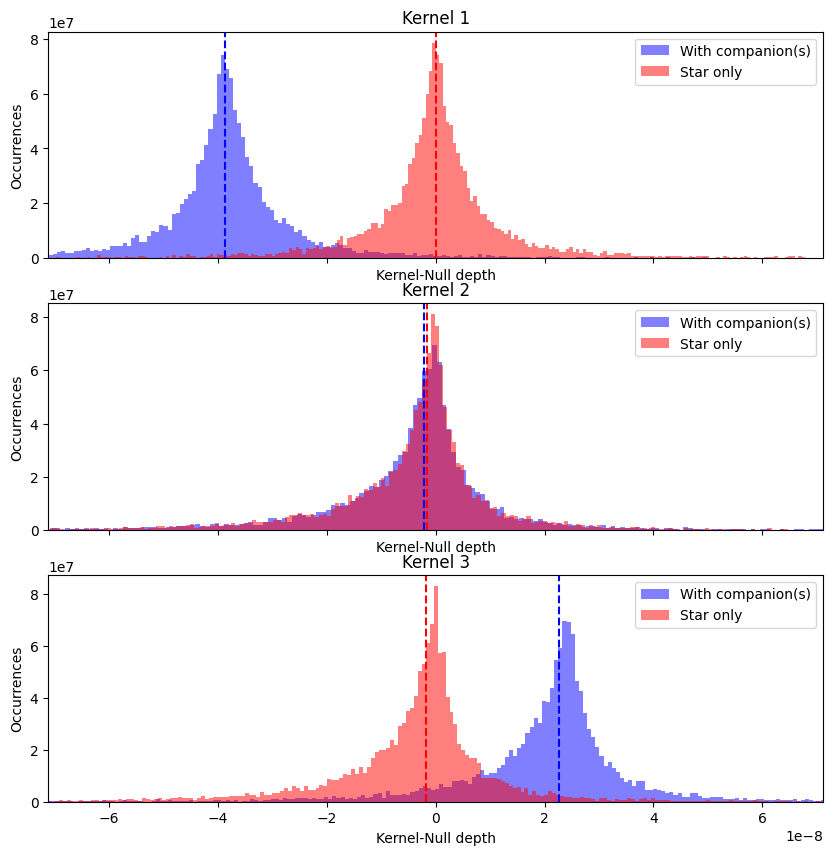

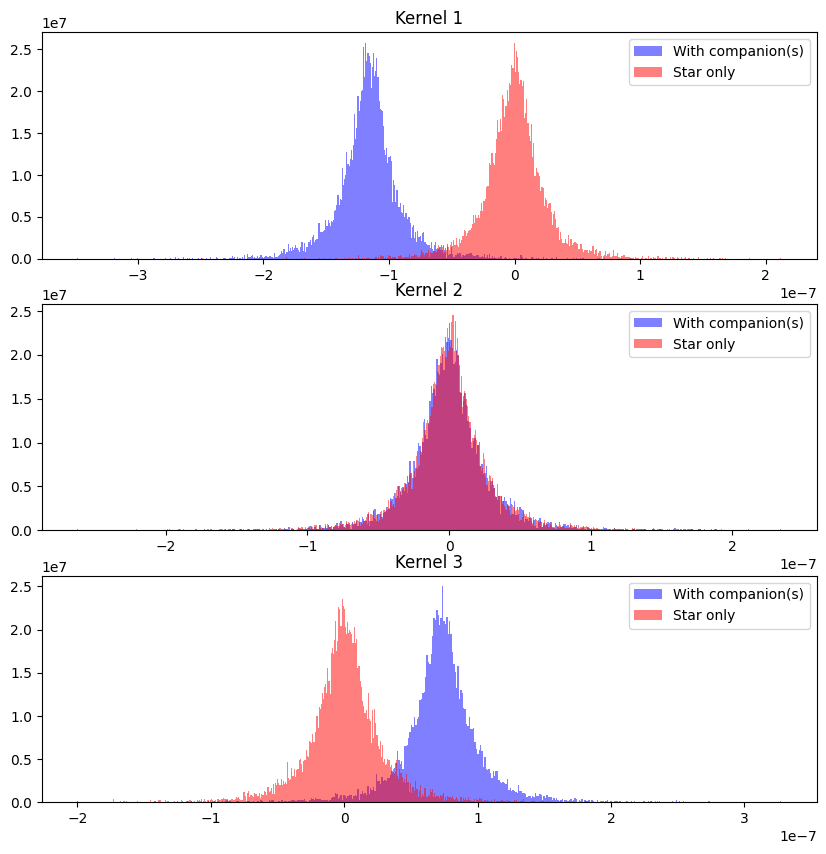

In [3]:
from src import analysis
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

ctx = analysis.contexts.get_VLTI()
ctx.interferometer.kn.σ = np.zeros(14) * u.nm
ctx.Γ = 1 * u.nm
ctx.target.companions[0].c = 1e-7
ctx.monochromatic = True
a_p, a_s = analysis.data_representations.instant_distribution(ctx)
ctx.interferometer.λ += 1*u.nm
b_p, b_s = analysis.data_representations.instant_distribution(ctx)
ctx.interferometer.λ -= 2*u.nm
c_p, c_s = analysis.data_representations.instant_distribution(ctx)

res_p = np.empty_like(a_p)
res_s = np.empty_like(a_p)
for k in range(3):
    res_p[:,k] = a_p[:,k] + b_p[:,k] + c_p[:,k]
    res_s[:,k] = a_s[:,k] + b_s[:,k] + c_s[:,k]

fig, axs = plt.subplots(3, 1, figsize=(10, 10))

for k in range(3):
    axs[k].hist(res_p[:,k], bins=500, color='blue', alpha=0.5, label='With companion(s)', density=True)
    axs[k].hist(res_s[:,k], bins=500, color='red', alpha=0.5, label='Star only', density=True)
    axs[k].legend()
    axs[k].set_title(f'Kernel {k+1}')


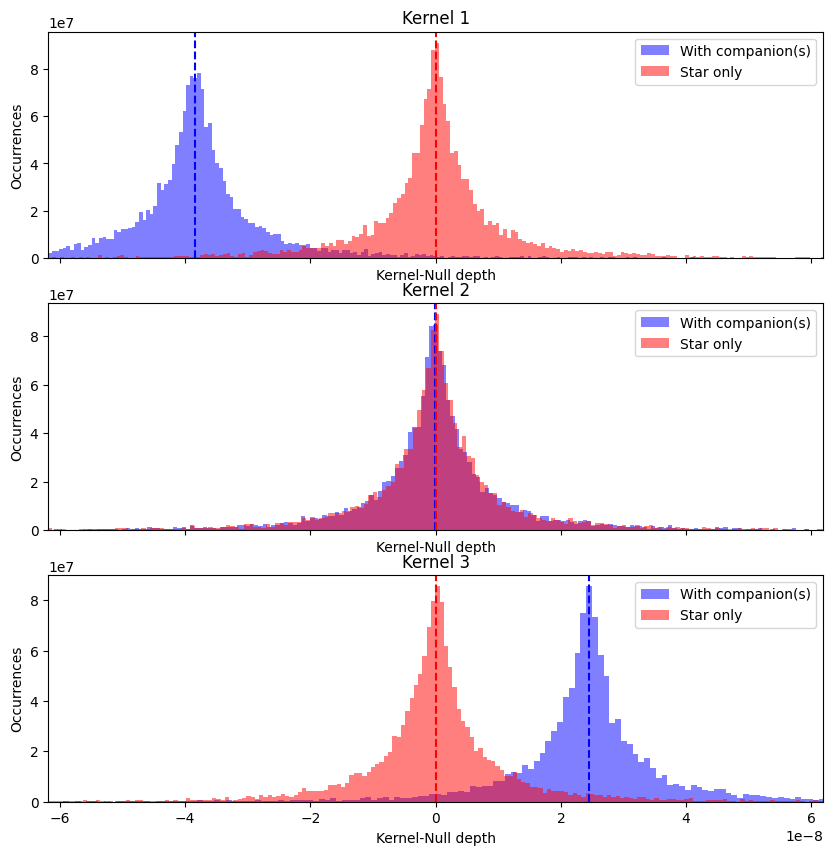

In [3]:
from src import analysis
import astropy.units as u
import numpy as np

ctx = analysis.contexts.get_VLTI()
ctx.interferometer.kn.σ = np.zeros(14) * u.nm
ctx.Γ = 1 * u.nm
ctx.target.companions[0].c = 1e-7
ctx.observe = ctx.observe_monochromatic
_ = analysis.data_representations.instant_distribution(ctx)

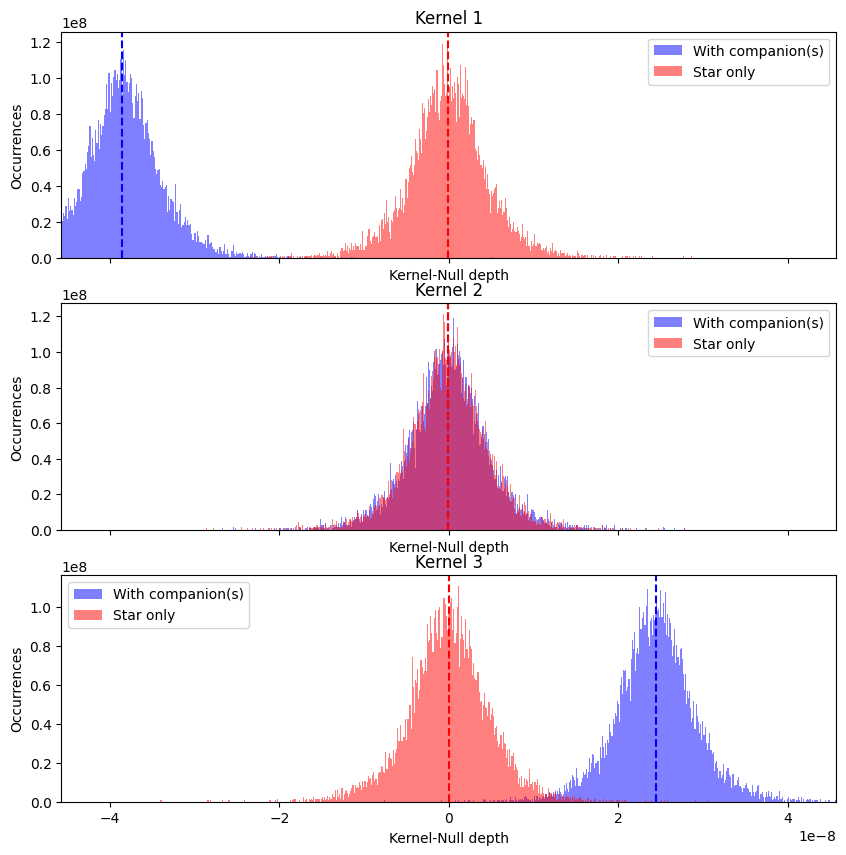

In [4]:
from src import analysis
import astropy.units as u
import numpy as np

ctx = analysis.contexts.get_VLTI()
ctx.interferometer.kn.σ = np.zeros(14) * u.nm
ctx.Γ = 1 * u.nm
ctx.target.companions[0].c = 1e-7
_ = analysis.data_representations.instant_distribution(ctx)

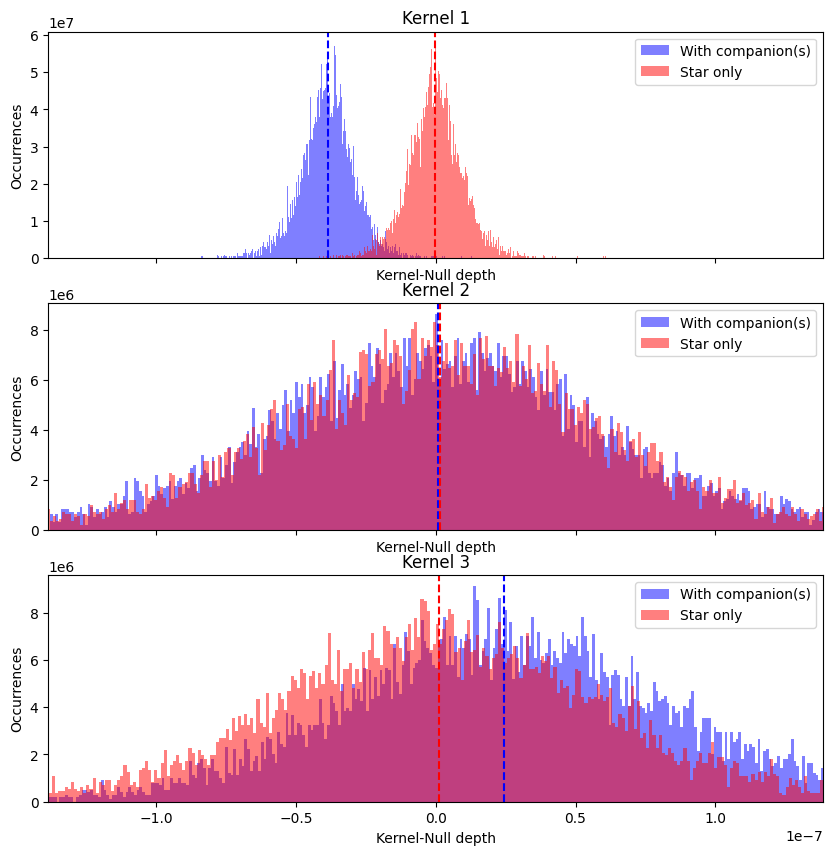

In [5]:
from src import analysis
import astropy.units as u
import numpy as np

ctx = analysis.contexts.get_VLTI()
ctx.interferometer.kn.σ = np.zeros(14) * u.nm
ctx.Γ = 1 * u.nm
ctx.target.companions[0].c = 1e-7
ctx.interferometer.Δλ = 20 * u.nm
_ = analysis.data_representations.instant_distribution(ctx)

## 🟡 Time serie

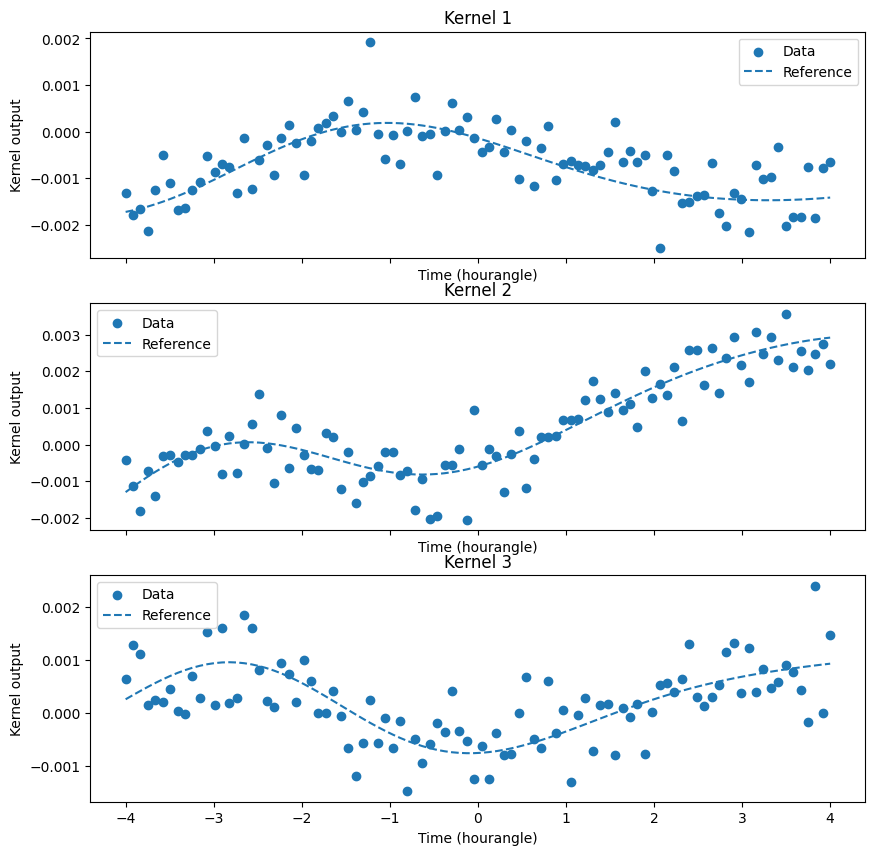

In [23]:
from src import analysis
import astropy.units as u
import numpy as np
from src import Companion

ctx = analysis.contexts.get_VLTI()
ctx.interferometer.λ = 1.65 * u.um
ctx.interferometer.kn.σ = np.zeros(14) * u.nm
ctx.target.companions = []
ctx.target.companions.append(
    Companion(
        c=1e-2,
        θ=2 * u.mas,
        α=3*np.pi/4 * u.rad,
    )
)

# ctx.target.companions.append(
#     Companion(
#         c=1e-8,
#         θ=8 * u.mas,
#         α=0 * u.rad,
#     )
# )
# ctx.calibrate_obs(1000)

data, data_ref = analysis.data_representations.time_evolution(ctx, n=60, map=np.median)

In [13]:
from src import analysis
analysis.temporal_response.gui()

(288,) (288,)
Optimized parameters: [0. 2.]
Target "Vega"
  f: 1.24e-12 W / (nm m2)
  δ: -9.00e+01 deg
  Companions:
    Companion "Hypothetical Companion"
      Contrast: 0.00
      Angular separation: 4.00 mas
      Parallactic angle: 0.00 rad


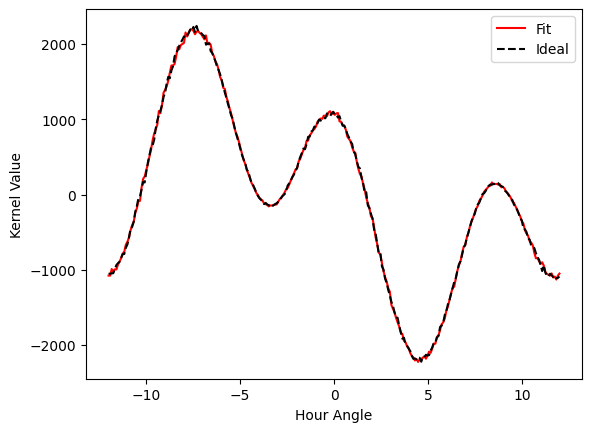

In [14]:
from src import analysis

ctx = analysis.contexts.get_LIFE()

analysis.temporal_response.fit(ctx)

---

<div align=center>

# 🔎 **Data analysis**

</div>

## 📢 Noise sensitivity

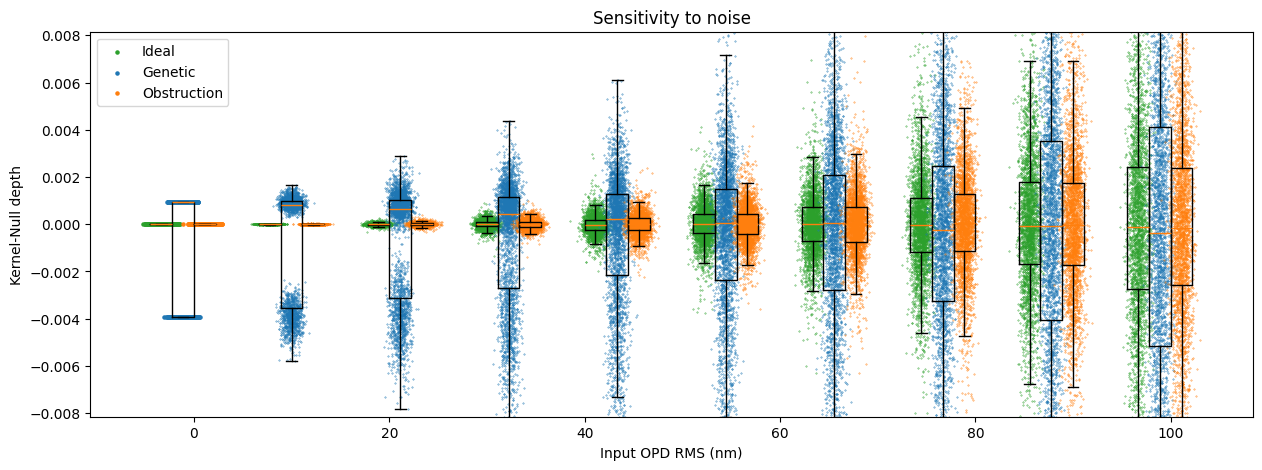

In [15]:
from src import analysis
analysis.noise_sensitivity.plot(β=0.961, n=1_000)

## ☑️ Model fitting (WIP)

Distributions are cool, but in order to make deeper analysis, we want to find a model that describe these distribution using few parameters. Unfortunately, there is no straightforward way to get such model as these distribution are very particular.

The next block try most of the common distribution models and show the best ones... but unfortunately, none of them seems to match 😞

⌛ Generating data...
✅ Data generation complete.
⌛ Fitting distributions...
✅ Cauchy fit complete.
✅ Laplace fit complete.
✅ Johnson SU fit complete.


d:\Tunable-Kernel-Nulling\src\analysis\distribution_model.py:51: RuntimeWarning: overflow encountered in sinh
  * np.exp(-0.5 * (γ + δ*np.sinh((x - μ) / σ))**2)
d:\Tunable-Kernel-Nulling\src\analysis\distribution_model.py:51: RuntimeWarning: overflow encountered in square
  * np.exp(-0.5 * (γ + δ*np.sinh((x - μ) / σ))**2)


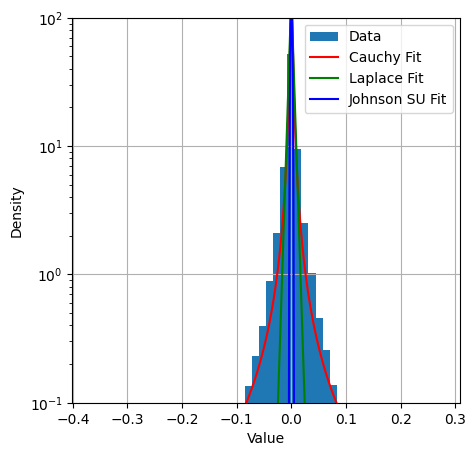

In [1]:
from src import analysis
import astropy.units as u
import numpy as np

ctx = analysis.contexts.get_VLTI()
# ctx.observe = ctx.observe_monochromatic
ctx.target.companions = []
ctx.interferometer.kn.σ = np.zeros(14) * u.nm
ctx.monochromatic = True

analysis.distribution_model.fit(ctx = ctx)

## 📈 Test statistics on distributions

A test statistic is a way of reducing the data we have to an unique number and compare this number to a threshold value. If the number is below the treshold, then the null hypothesis is favored. If it is above, the alternative hypothesis is favored. The goal is to find the best test statistic that allow to distinguish both hypothesis in a correct way

- $H0$: the null hypothesis -> there is no planet
- $H1$: the alternative hypothesis -> there is a planet

- $T0$: vector of distributions obtained with H0
- $T1$: vector of distributions obtained with H1

We don't have access to an appropriate model thatt well describe the distributions we obtain. However, we can empirically determine that the measured data can be expressed such as:

$$
x_i = \alpha S_p + n_i(S_p)
$$

With
- $\hat{S_p}$ the signal of the planet
- $\alpha$ is a coefficient that scales this signal (instrumental response). It lives in $[0,1]$
- $n$ is a noise term (combine all the noise sources)

The only thing we know about $n(S_p)$ is that the distribution it follows seems to be flattened when $S_p$ increases.

In [2]:
import src.analysis.distrib_test_statistics as ts
import numpy as np
import astropy.units as u

from src import analysis

ctx = analysis.contexts.get_VLTI()

ctx.interferometer.kn.σ = np.zeros(14) * u.nm
ctx.target.companions[0].c = 1e-2

ctx.monochromatic = True

T0, T1 = ts.get_vectors(ctx=ctx, nmc=100, size=1000)


e:\Tunable-Kernel-Nulling\src\classes\context.py:786: SyntaxWarning: invalid escape sequence '\p'
  axs[*plt_coords].set_title(f"$|B(\phi{p})|$")
e:\Tunable-Kernel-Nulling\src\classes\context.py:812: SyntaxWarning: invalid escape sequence '\p'
  axs[*plt_coords].set_title(f"$K_{m}(\phi{p})$")
e:\Tunable-Kernel-Nulling\src\classes\context.py:838: SyntaxWarning: invalid escape sequence '\p'
  axs[*plt_coords].set_title(f"$|D_{ds[0]}(\phi{p})| + |D_{ds[1]}(\phi{p})|$")
e:\Tunable-Kernel-Nulling\src\classes\context.py:838: SyntaxWarning: invalid escape sequence '\p'
  axs[*plt_coords].set_title(f"$|D_{ds[0]}(\phi{p})| + |D_{ds[1]}(\phi{p})|$")
e:\Tunable-Kernel-Nulling\.venv\Lib\site-packages\fitter\__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
e:\Tunable-Kern

Vectors generation complete ✅


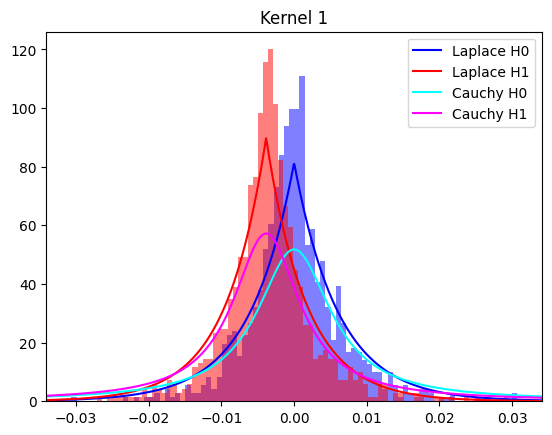

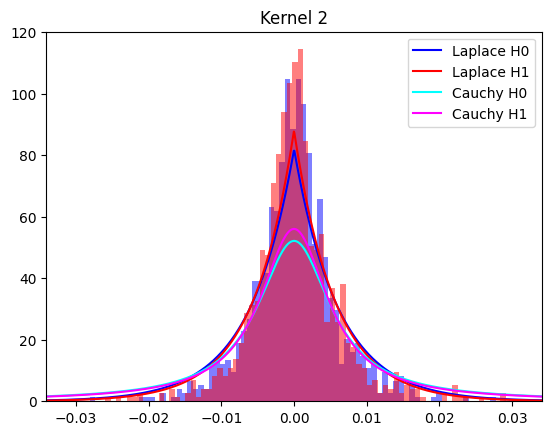

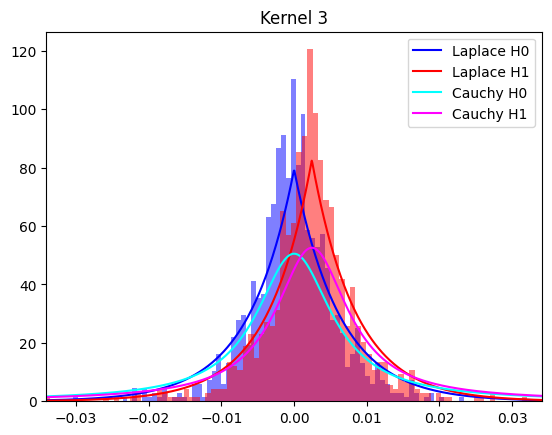

In [3]:
from copy import deepcopy as copy
import matplotlib.pyplot as plt
from scipy.stats import laplace, cauchy

def get_dists(ctx, N=1000):
    dists = np.empty((3, N))
    for i in range(N):
        _, k, b = tmp_ctx.observe()
        k /= b
        dists[:, i] = k
    return dists

def get_sigma(x, μ):
    mads = np.empty(3)
    for k in range(3):
        mad = np.median(np.abs(x[k, :] - μ[k]))
        b_mad = mad / np.log(2)
        sigma_mad = np.sqrt(2) * b_mad
        mads[k] = sigma_mad
    return mads

# Ideal case ------------------------------------------------------------------

tmp_ctx = copy(ctx)
tmp_ctx.monochromatic = False
tmp_ctx.Γ = 0 * u.m
tmp_ctx.interferometer.camera.ideal = True
μ1 = get_dists(tmp_ctx, N=1)[:,0]
tmp_ctx.target.companions = []
μ0 = get_dists(tmp_ctx, N=1)[:,0]

# Realistic case --------------------------------------------------------------

tmp_ctx = copy(ctx)
tmp_ctx.monochromatic = False

k1 = get_dists(tmp_ctx)
tmp_ctx.target.companions = []
k0 = get_dists(tmp_ctx)

# Dispersion
σ0 = get_sigma(k0, μ0)
σ1 = get_sigma(k1, μ1)

# Plotting --------------------------------------------------------------------

lims = np.max(np.abs(μ1)) + 5*np.max(σ1)
x = np.linspace(-lims, lims, 1000)

for k in range(3):
    laplace_pdf0 = laplace.pdf(x, loc=μ0[k], scale=σ0[k])
    laplace_pdf1 = laplace.pdf(x, loc=μ1[k], scale=σ1[k])
    plt.plot(x, laplace_pdf0, label='Laplace H0', color='blue')
    plt.plot(x, laplace_pdf1, label='Laplace H1', color='red')
    cauchy_pdf0 = cauchy.pdf(x, loc=μ0[k], scale=σ0[k])
    cauchy_pdf1 = cauchy.pdf(x, loc=μ1[k], scale=σ1[k])
    plt.plot(x, cauchy_pdf0, label='Cauchy H0', color='cyan')
    plt.plot(x, cauchy_pdf1, label='Cauchy H1', color='magenta')
    plt.hist(k0[k,:], bins=100, density=True, alpha=0.5, color='blue', log=False)
    plt.hist(k1[k,:], bins=100, density=True, alpha=0.5, color='red', log=False)
    plt.legend()
    plt.title(f'Kernel {k+1}')
    plt.xlim(-lims, lims)
    plt.show()

### Mean

**Principle:** We take the average of the distribution and we compare it to a treshold.

$$
\left|\frac{1}{N}\sum_i x_i \right| \stackrel{H_1}{\underset{H_0}{\gtrless}} \xi
$$

$$
\begin{cases}
H_0 : d = |\bar{n}|\\
H_1 : d =  |\alpha \hat{S_p} + \bar{n}|
\end{cases}
$$

### Median

**Principle:** We take the median of the distribution and we compare it to a treshold.

$$
\begin{cases}
\left| x_{\frac{N+1}{2}} \right| & \text{if }N\text{ is odd} \\

\left| \frac{x_{\frac{N}{2}} + x_{\frac{N+1}{2}}}{2} \right|  & \text{if }N\text{ is odd}
\end{cases}
\quad\stackrel{H_1}{\underset{H_0}{\gtrless}} \xi
$$

$$
\begin{cases}
H_0 : d = |\tilde{n}|\\
H_1 : d =  | \alpha \hat{S_p} + \tilde{n} |
\end{cases}
$$

### Argmax

**Principle:** We pack our data in bins and we consider the position of the bin with the highest number of occurences. We compare it to a treshold.

### Kolmogorov-Smirnov

**Principle:** We compare the maximum distance on the cumulative distribution functions of the two distributions.

### Cramèr-von Mises

**Principle:** We compare the total quadratique distance on the cumulative distribution functions of the two distributions.

### Wilcoxon-Mann-Whitney (WIP)

### CDF diff area

### Flattening

$$
\sum_{i=1}^{N} |x_i - \tilde{x}| \stackrel{H_1}{\underset{H_0}{\gtrless}} \xi
$$

with $\tilde{x} = \text{median}(x)$


$$
\begin{cases}
H_0 : d = \sum |n - \tilde{n}|\\
H_1 : d = \sum \frac{|n - \tilde{n}|}{\beta(\hat{S_p})}
\end{cases}
$$

### Median of abs


$$
\begin{cases}
H_0 : d = \tilde{\text{abs}(n)}\\
H_1 : d = \alpha \times \hat{\text{abs}(S_p)} + \frac{\tilde{\text{abs}(n)}}{\beta(\hat{S_p})}
\end{cases}
$$

## ❓ ROC curves

ROC curves allow to compare the power of different test statistics. It show the proportion of true detection in function of the probability of false alarm. The more the curve climb fast, the better it is.

Power of Mean: 1.79%
Power of Median: 63.31%
Power of Kolmogorov-Smirnov: 93.16%
Power of Flattening: 43.62%
Power of Median + Flattening: 50.12%
Power of Median of Abs: 97.98%


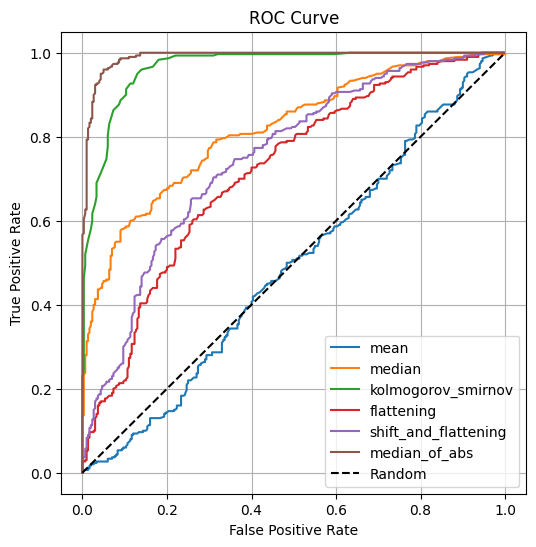

In [6]:
ts.plot_rocs(t0=T0, t1=T1)

## 💪 Tests power

e:\Tunable-Kernel-Nulling\.venv\Lib\site-packages\fitter\__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Bootstrap 1/3...
Vectors generation complete ✅
Done computing tests power ✅
Bootstrap 2/3...
Vectors generation complete ✅
Done computing tests power ✅
Bootstrap 3/3...
Vectors generation complete ✅
Done computing tests power ✅


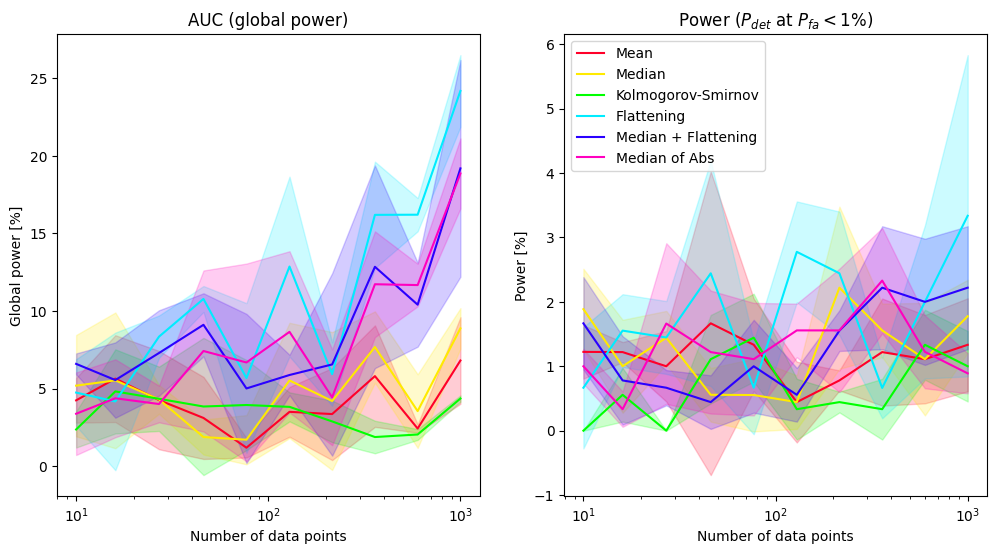

In [1]:
from src import analysis
import src.analysis.distrib_test_statistics as ts
import numpy as np
import astropy.units as u

ctx = analysis.contexts.get_LIFE()
ctx.interferometer.kn.σ = np.zeros(14) * u.nm
ctx.target.companions[0].c = 1e-9

ts.test_power(ctx=ctx, bootstrap=3, nmc=100, resolution=10, maxpoints=1000)

Bootstrap 1/3...
Vectors generation complete ✅
Done computing tests power ✅
Bootstrap 2/3...
Vectors generation complete ✅
Done computing tests power ✅
Bootstrap 3/3...
Vectors generation complete ✅
Done computing tests power ✅


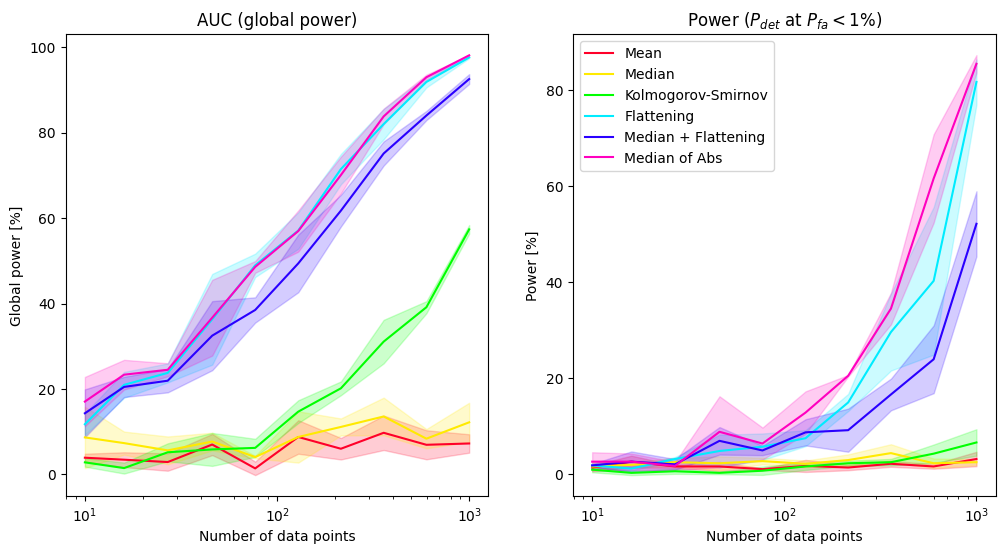

In [2]:
from src import analysis
import src.analysis.distrib_test_statistics as ts
import numpy as np
import astropy.units as u

ctx = analysis.contexts.get_VLTI()
ctx.interferometer.kn.σ = np.zeros(14) * u.nm
ctx.target.companions[0].c = 1e-2

ts.test_power(ctx=ctx, bootstrap=3, nmc=100, resolution=10, maxpoints=1000)

Vectors generation complete ✅


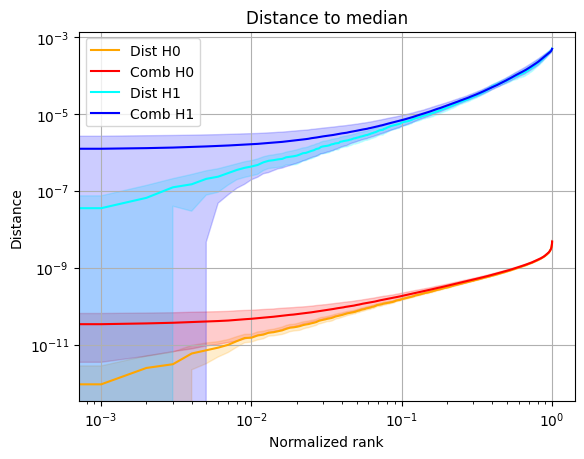

In [3]:
import src.analysis.distrib_test_statistics as ts
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

ctx = analysis.contexts.get_LIFE()
ctx.interferometer.kn.σ = np.zeros(14) * u.nm
ctx.target.companions[0].c = 1e-3

size = 1000
t0, t1 = ts.get_vectors(ctx=ctx, nmc=10, size=size)

x = np.linspace(0, 1, size)

def compute(t):
    shifts = np.median(t, axis=1)
    mean_shift = np.mean(shifts, axis=0)
    std_shift = np.std(shifts, axis=0)

    distances = np.empty_like(t)
    for i in range(t.shape[0]):
        distances[i] = np.sort(np.abs(t[i] - shifts[i]))
    mean_distances = np.median(distances, axis=0)
    std_distances = np.std(distances, axis=0)

    comb = distances.copy()
    for i in range(t.shape[0]):
        comb[i] += np.abs(shifts[i])
    mean_comb = np.mean(comb, axis=0)
    std_comb = np.std(comb, axis=0)

    return mean_shift, mean_distances, mean_comb, std_shift, std_distances, std_comb

# H0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

s0, d0, c0, σs0, σd0, σc0 = compute(t0)

# plt.plot(x, np.ones(len(x)) * s0, label='Median H0', linestyle='--', color='orange')
# plt.fill_between(x, s0 - σs0, s0 + σs0, color='orange', alpha=0.2)

plt.plot(x, d0, label='Dist H0', color='orange')
plt.fill_between(x, d0 - σd0, d0 + σd0, color='orange', alpha=0.2)

plt.plot(x, c0, label='Comb H0', color='red')
plt.fill_between(x, c0 - σc0, c0 + σc0, color='red', alpha=0.2)

# H1 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

s1, d1, c1, σs1, σd1, σc1 = compute(t1)

# plt.plot(x, np.ones(len(x)) * s1, label='Median H1', linestyle='--', color='aqua')
# plt.fill_between(x, s1 - σs1, s1 + σs1, color='aqua', alpha=0.2)

plt.plot(x, d1, label='Dist H1', color='aqua')
plt.fill_between(x, d1 - σd1, d1 + σd1, color='aqua', alpha=0.2)

plt.plot(x, c1, label='Comb H1', color='blue')
plt.fill_between(x, c1 - σc1, c1 + σc1, color='blue', alpha=0.2)

# Plot parameters ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

plt.title('Distance to median')
plt.xlabel('Normalized rank')
plt.ylabel('Distance')
plt.legend()
# Logscale
plt.yscale('log')
plt.xscale('log')
plt.grid()

plt.show()

## Likelihood Ratio

$$
\Lambda(x) = \frac{p(x|H_0)}{p(x|H_1)}
$$

Where $p(x|H_0)$ and $p(x|H_1)$ are the probability density functions of the data $x$ under the null hypothesis $H_0$ and the alternative hypothesis $H_1$ respectively.

### Gaussian case

If we consider that the data follow a Gaussian distribution, we can express the likelihood ratio as:

$$
\Lambda(x) = \frac{\sigma_1}{\sigma_0} \exp\left(\frac{(x - \mu_1)^2}{2\sigma_1^2} - \frac{(x - \mu_0)^2}{2\sigma_0^2}\right)
$$

Where $\mu_0$ and $\sigma_0$ are the mean and standard deviation of the distribution under $H_0$, and $\mu_1$ and $\sigma_1$ are the mean and standard deviation of the distribution under $H_1$.

### Laplacian case

If we consider that the data follow a Laplacian distribution, we can express the likelihood ratio as:

$$
\Lambda(x) = \frac{b_1}{b_0} \exp\left(\frac{|x - \mu_1|}{b_1} - \frac{|x - \mu_0|}{b_0}\right)
$$

Where $\mu_0$ and $b_0$ are the mean and scale parameter of the distribution under $H_0$, and $\mu_1$ and $b_1$ are the mean and scale parameter of the distribution under $H_1$.

### Cauchy case

If we consider that the data follow a Cauchy distribution, we can express the likelihood ratio as:

$$
\Lambda(x) = \frac{\gamma_1(1+(\frac{x - x_1}{\gamma_1})^2)}{\gamma_0(1+(\frac{x - x_0}{\gamma_0})^2)}
$$

Where $x_0$ and $\gamma_0$ are the location and scale parameters of the distribution under $H_0$, and $x_1$ and $\gamma_1$ are the location and scale parameters of the distribution under $H_1$.

## ✔️ P-values

The P-value is an indicator of the confidence we have to reject the null hypothesis.

The principle consist in comparing the test statistic obtain on the data we want to test with a large bunch of data that we know to be under the null hypothesis. We then compute the proportion of test statistic that are above the one we obtained. This proportion is the P-value.

Thus, the lower the P-value, the more confident we are to reject the null hypothesis. A P-value below 0.05 is commonly considered as a good indicator to reject the null hypothesis.

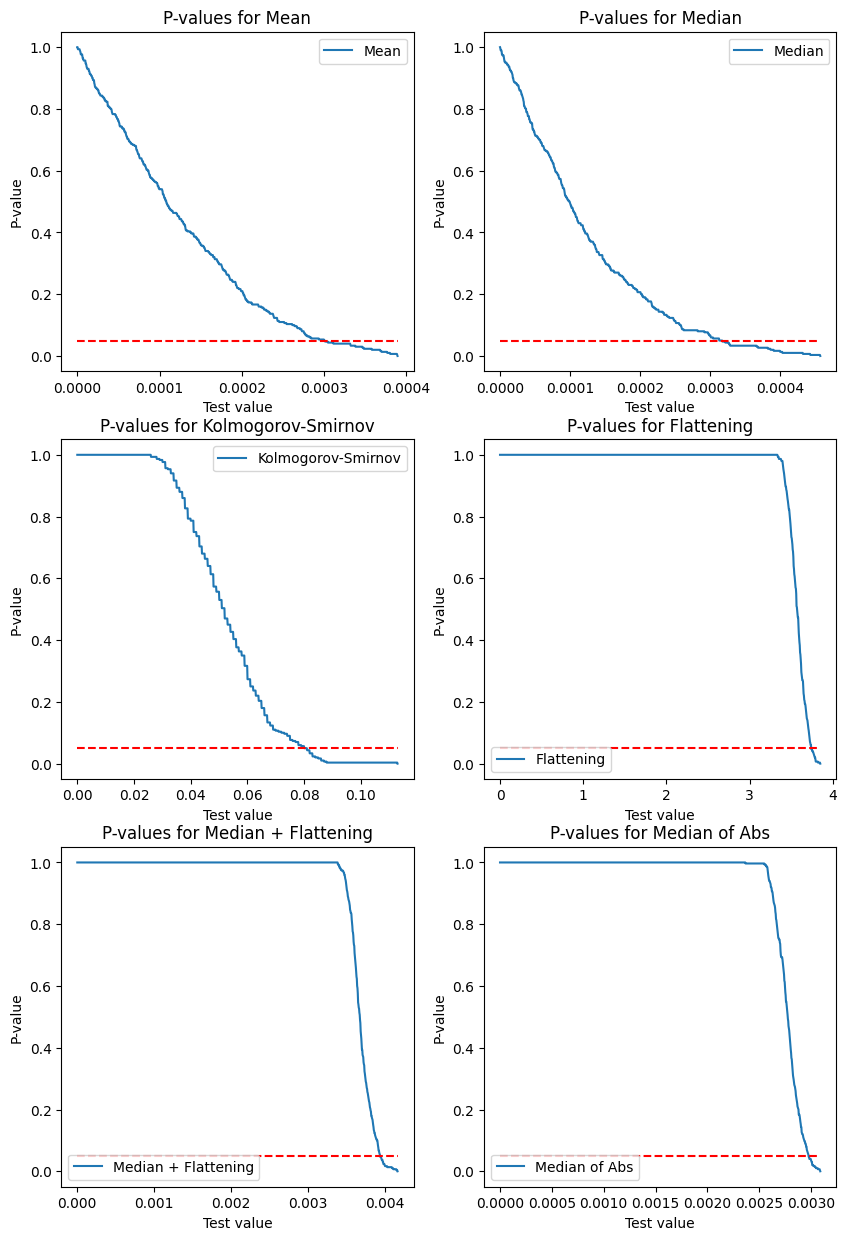

In [7]:
ts.plot_p_values(t0=T0, t1=T1)

---

<div align=center>

# 🪐 **Characterization**

</div>

## ♒ Modulation fit

In order to determine the planet position, we need to rotate the interferometer baseline in order to rotate the transmission map. Thus, the planet signal will be modulated. By analysis this modulation (trying to fit the parametrized modulation function to the data points), it is possible to retrieve the planet position.

## ♈ Modulation spectrum

Kernel 1


NameError: name 'data' is not defined

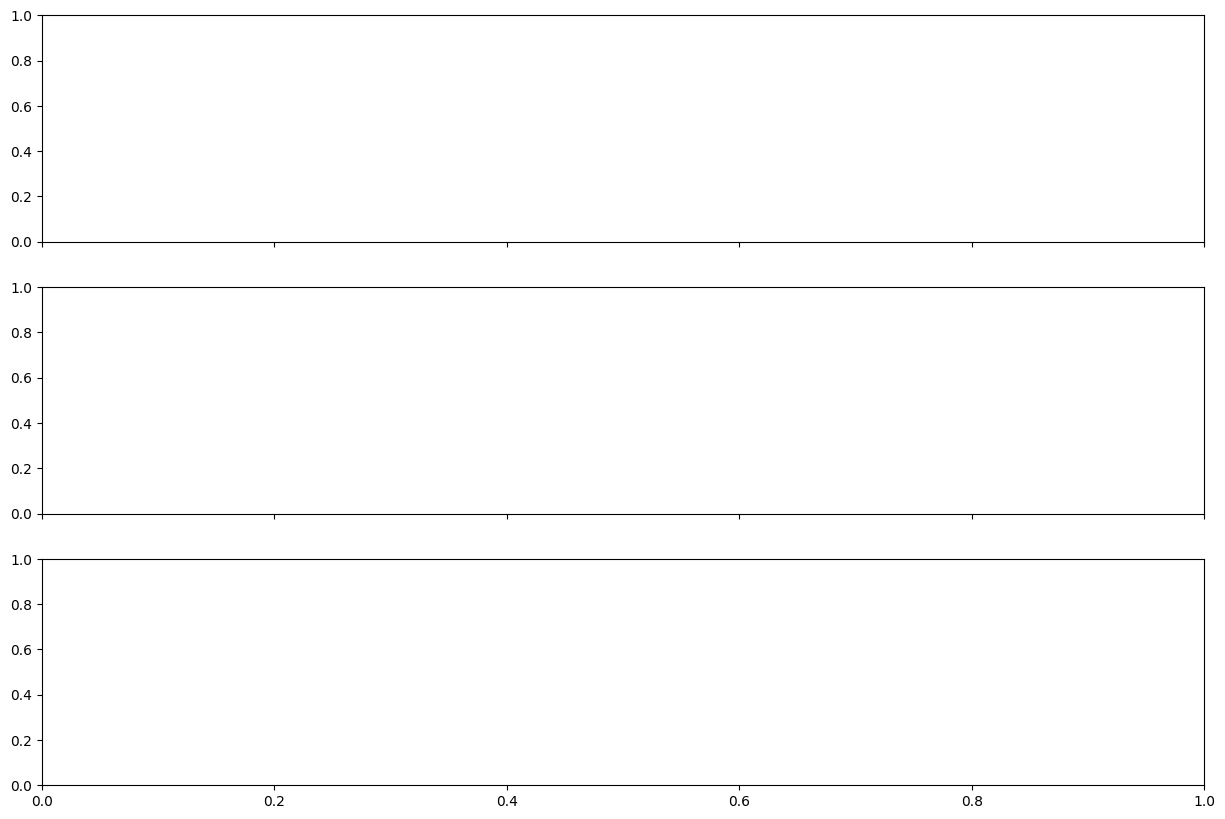

In [8]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
axs = axs.flatten()

for k in range(3):

    print(f"Kernel {k+1}")

    for key, value in {'Data': data, 'Reference': data_ref}.items():

        signal = value[:, k]  # On prend le premier signal pour l'analyse
        dt = ctx.interferometer.camera.e.to(u.s).value
        N = len(signal)

        # Application d'une fenêtre de Hanning pour réduire les effets de bord
        window = np.hanning(N)
        signal = signal * window

        # Zero-padding à, disons, 10× la longueur originale
        Npad = 10 * N
        padded_signal = np.zeros(Npad)
        padded_signal[:N] = signal

        # Calcul de la transformée de Fourier
        frequencies = np.fft.fftfreq(Npad, d=dt)  # axe des fréquences
        spectrum = np.fft.fft(padded_signal)  # spectre complexe

        # On garde uniquement la moitié positive (utile pour signaux réels)
        positive_freqs = frequencies[:Npad // 2]
        positive_spectrum = np.abs(spectrum[:Npad // 2])  # module

        # Position des maximums locaux
        max_indices = np.where(
            (positive_spectrum[1:-1] > positive_spectrum[:-2]) & 
            (positive_spectrum[1:-1] > positive_spectrum[2:])
        )[0] + 1
        peaks = positive_freqs[max_indices[:3]]

        if key == "Data":
            data_peaks = peaks
        else:
            ref_peaks = peaks
        
        print("  ", key, "pics:", peaks, "Hz")

        axs[k].plot(positive_freqs, positive_spectrum / np.max(positive_spectrum), label=key)

    print("   Relative difference:", np.sum(np.abs(1 - (data_peaks / ref_peaks))))

    axs[k].set_title(f'Freq. on kernel {k+1}')
    axs[k].legend()
    axs[k].set_xlabel('Fréquence (Hz)')
    axs[k].set_ylabel('Amplitude')
    axs[k].grid(True)
plt.show()

## 🌌 On-sky contribution

From the obtained data, it is possible to build a 2D distribution of the perceived sky contribution zones. This distribution provides insights into the possible locations of objects, enabling accurate initial estimations to fit the data points obtained based on the parallactic angle.

This method involves stacking the transmission maps rotated by the baseline rotation and weighting each map by the corresponding data obtained for that baseline rotation.

The base idea was already explored as "image reconstruction" technic using classical nulling interferometry $^1$. However, the method here is based on Kernel-Nulls which makes it more complex but less sensitive to phase aberations and by considerig the different Kernels, we can reduce the degeneracy of the solutions.

Considering:
- $T_{n}$ represents the n-th kernel's normalized transmission map.
- $d_{n,\beta}$ denotes the data point obtained for kernel $n$ with baseline rotation $\beta$.
- $\alpha$ is the parallactic angle.
- $\theta$ is the angular separation.

$$
r_n(\theta, \alpha) = \sum_a T_{n,h}(\theta,\alpha) d_{n,h}
$$


As the kernel outputs are antisymetric, we can filter the negative contributions:
$$
r'_n = \frac{1}{2}\max(r_n, 0)
$$


Finally, we can compute the product over all the kernels to get the final contribution zones:
$$
C(\theta, \alpha) = \prod_n r'_n(\theta, \alpha)
$$

**References:**
1. Angel, J. R. P., et N. J. Woolf. "An Imaging Nulling Interferometer to Study Extrasolar Planets". *The Astrophysical Journal* 475, no 1 (1997): 373‑79. https://doi.org/10.1086/303529.

In [ ]:
from src import analysis
from src import Companion
import astropy.units as u
import numpy as np

ctx = analysis.contexts.get_VLTI()
ctx.Γ = 1 * u.nm
ctx.Δh = 8 * u.hourangle
ctx.interferometer.λ = 1.65/2 * u.um
ctx.interferometer.kn.φ = np.zeros(14) * u.nm
ctx.interferometer.kn.σ = np.zeros(14) * u.nm
ctx.interferometer.camera.e = 5 * u.min
for t in ctx.interferometer.telescopes:
    t.r *= 1
ctx.target.companions[0].c = 1e-3

nb_photons = int(np.sum(ctx.pf).to(1/u.s) * ctx.interferometer.camera.e.to(u.s) * ctx.target.companions[0].c)
print(f"Expected photons from the planet: {nb_photons:.2e}")

analysis.sky_contribution.plot(ctx)

## ♊ Correlation map (WIP)

In [ ]:
# def correlation_map(
#         data=HOUR_DIVERSITY_DATA,
#         h_range=H_RANGE,
#     ):

#     resolution = 20
    
#     _, _, alpha_map, theta_map = get_uv_map(resolution=resolution)

#     correl_map = np.zeros((resolution, resolution))

#     for x in range(resolution):
#         for y in range(resolution):

#             alpha = alpha_map[x, y]
#             theta = theta_map[x, y]

#             km = kernels_modulation(h_range, alpha=alpha, theta=theta)[0]

#             correl_map[x, y] = np.sum(np.corrcoef(data[0], km))


#     _, ax = plt.subplots(1, 1, figsize=(15, 15))
#     im = ax.imshow(correl_map)
#     plt.colorbar(im, ax=ax)
#     ax.set_title("Correlation map")

#     plt.show()

# correlation_map()